In [4]:
!ls /content/drive/MyDrive/LTMM/

'ls' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


# 1.Utils 

In [5]:
import numpy as np

In [6]:
def upshift(a, index, n):
  '''
  Shift the collumn with index with numpy.roll(collumn, -n)
  '''
  col = a[:, index]
  shift_col = np.roll(col, -n)
  for i in range(len(a)):
    a[i][index] = shift_col[i]
  
  return a

In [7]:
def downshift(a, index, n):
  '''
  Shift the collumn with index with numpy.roll(collumn, n)
  '''
  col = a[:, index]
  shift_col = np.roll(col, n)
  for i in range(len(a)):
    a[i][index] = shift_col[i]
  
  return a

In [8]:
def rotate(n):
  '''
  Rotate 180 the binary bit string of n and convert to integer
  '''
  bits = "{0:b}".format(n)
  return int(bits[::-1], 2)

In [9]:
a = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(a.shape)
print("Before: ")
print(a)
a = upshift(a, 0, 1) if sum(a[0]) % 2 else downshift(a, 0, 1)
print("After: ")
print(a)

(3, 3)
Before: 
[[1 2 3]
 [4 5 6]
 [7 8 9]]
After: 
[[7 2 3]
 [1 5 6]
 [4 8 9]]


# 2.Encrypt

In [10]:
from PIL import Image
import cv2
import random
import numpy as np
import sys
from Aes import *
import json


##  2.1 Image functions

In [11]:
def read_image(image_path):
  image = Image.open(image_path)
  image = np.array(image)
  return image

In [12]:
def save_image(image, image_save_path):
  save_img = Image.fromarray(image)
  save_img = save_img.save(image_save_path)
  return

## 2.2 Key functions

In [13]:
def create_key(image, ITER_MAX=2, alpha=8, aes=None):
    # Create vector Kr and Kc
    Kr = [random.randint(0, 2 ** alpha - 1) for i in range(image.shape[0])]
    Kc = [random.randint(0, 2 ** alpha - 1) for i in range(image.shape[1])]

    dict_key = {"Kr": Kr,
                "Kc": Kc,
                "ITER": ITER_MAX
                }
    if aes is not None:
        dict_key = encrypt(dict_key, aes)
    return dict_key

In [14]:
def save_key(dict_key, save_path="./key.json"):
  with open(save_path, "w") as F:
    json.dump(dict_key, F, indent=4)

In [15]:
def load_key(save_path="./key.json", aes=None):
    with open(save_path, "r") as F:
        dict_key = json.load(F)

    if aes is not None:
        dict_key = decrypt(dict_key, aes)

    Kr = dict_key["Kr"]
    Kc = dict_key["Kc"]
    ITER_MAX = dict_key["ITER"]

    return Kr, Kc, ITER_MAX

## 2.3 Encrypt function

In [16]:
def encrypt_image(image, key_path="./key.json", aes=None):
  # Load Key
  Kr, Kc, ITER_MAX = load_key(save_path=key_path, aes=aes)

  # Split channels
  r = np.array(image[:, :, 0])
  g = np.array(image[:, :, 1])
  b = np.array(image[:, :, 2])

  for iter in range(ITER_MAX):
    # For each row
    for i in range(image.shape[0]):
      r_modulus = sum(r[i]) % 2 
      g_modulus = sum(g[i]) % 2
      b_modulus = sum(b[i]) % 2
      r[i] = np.roll(r[i], -Kr[i]) if r_modulus else np.roll(r[i], Kr[i])
      g[i] = np.roll(g[i], -Kr[i]) if g_modulus else np.roll(g[i], Kr[i])
      b[i] = np.roll(b[i], -Kr[i]) if b_modulus else np.roll(b[i], Kr[i])
  
    # For each column 
    for i in range(image.shape[1]):
      r_modulus = sum(r[:, i]) % 2
      g_modulus = sum(g[:, i]) % 2
      b_modulus = sum(b[:, i]) % 2
      r = downshift(r, i, Kc[i]) if r_modulus else upshift(r, i, Kc[i])
      g = downshift(g, i, Kc[i]) if g_modulus else upshift(g, i, Kc[i])
      b = downshift(b, i, Kc[i]) if b_modulus else upshift(b, i, Kc[i])

    # For each row
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        if(i%2==1):
          r[i][j] = r[i][j] ^ Kc[j]
          g[i][j] = g[i][j] ^ Kc[j]
          b[i][j] = b[i][j] ^ Kc[j]
        else:
          r[i][j] = r[i][j] ^ rotate(Kc[j])
          g[i][j] = g[i][j] ^ rotate(Kc[j])
          b[i][j] = b[i][j] ^ rotate(Kc[j])

    # For each column
    for j in range(image.shape[1]):
      for i in range(image.shape[0]):
        if(j%2==0):
          r[i][j] = r[i][j] ^ Kr[i]
          g[i][j] = g[i][j] ^ Kr[i]
          b[i][j] = b[i][j] ^ Kr[i]
        else:
          r[i][j] = r[i][j] ^ rotate(Kr[i])
          g[i][j] = g[i][j] ^ rotate(Kr[i])
          b[i][j] = b[i][j] ^ rotate(Kr[i])
  
  encrypted_img = np.stack((r,g,b), axis=2)
  return encrypted_img

## 2.3 Encrypt

In [ ]:
import matplotlib.pyplot as plt
image_path = r"C:\Users\Acer\github\RubikCube-AES-ImageEncryption\images\irisFlower.jpeg"
key_path = "./key.json"
encrypted_path = r"C:\Users\Acer\github\RubikCube-AES-ImageEncryption\images\Test.jpeg"
master_key = 0x2b7e151628aed2a6abf7158809cf4f3c
aes = AES(master_key)
# aes = None

image = read_image(image_path)

dict_key = create_key(image, ITER_MAX=1, aes=aes)

save_key(dict_key, save_path=key_path)

en_image = encrypt_image(image, aes=aes)
save_image(en_image, encrypted_path)
fig , ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(en_image)
ax[1].set_title("Encrypted Image")
fig.show()

4
44


TypeError: 'str' object cannot be interpreted as an integer

# 3.Decrypt 

In [ ]:
import cv2 
import random
import numpy as np
import sys

## 3.1 Decrypt function

In [ ]:
def decrypt_image(encrypted_image, key_path="./key.json", aes=None):
  # Load key
  Kr, Kc, ITER_MAX = load_key(save_path=key_path, aes=aes)

  # Split channels
  r = np.array(encrypted_image[:, :, 0])
  g = np.array(encrypted_image[:, :, 1])
  b = np.array(encrypted_image[:, :, 2])

  for iteration in range(ITER_MAX):
    # For each column
    for j in range(encrypted_image.shape[1]):
      for i in range(encrypted_image.shape[0]):
        if(j%2==0): 
          r[i][j] = r[i][j] ^ Kr[i]
          g[i][j] = g[i][j] ^ Kr[i]
          b[i][j] = b[i][j] ^ Kr[i]
        else:
          r[i][j] = r[i][j] ^ rotate(Kr[i])
          g[i][j] = g[i][j] ^ rotate(Kr[i])
          b[i][j] = b[i][j] ^ rotate(Kr[i])
  
    # For each row
    for i in range(encrypted_image.shape[0]):
      for j in range(encrypted_image.shape[1]):
        if(i%2==1):
          r[i][j] = r[i][j] ^ Kc[j]
          g[i][j] = g[i][j] ^ Kc[j]
          b[i][j] = b[i][j] ^ Kc[j]
        else:
          r[i][j] = r[i][j] ^ rotate(Kc[j])
          g[i][j] = g[i][j] ^ rotate(Kc[j])
          b[i][j] = b[i][j] ^ rotate(Kc[j])

    # For each column 
    for i in range(encrypted_image.shape[1]):
      r_modulus = sum(r[:, i]) % 2
      g_modulus = sum(g[:, i]) % 2
      b_modulus = sum(b[:, i]) % 2
      r = upshift(r, i, Kc[i]) if r_modulus else downshift(r, i, Kc[i])
      g = upshift(g, i, Kc[i]) if g_modulus else downshift(g, i, Kc[i])
      b = upshift(b, i, Kc[i]) if b_modulus else downshift(b, i, Kc[i])

    # For each row
    for i in range(encrypted_image.shape[0]):
      r_modulus = sum(r[i]) % 2 
      g_modulus = sum(g[i]) % 2
      b_modulus = sum(b[i]) % 2
      r[i] = np.roll(r[i], Kr[i]) if r_modulus else np.roll(r[i], -Kr[i])
      g[i] = np.roll(g[i], Kr[i]) if g_modulus else np.roll(g[i], -Kr[i])
      b[i] = np.roll(b[i], Kr[i]) if b_modulus else np.roll(b[i], -Kr[i])
  
  decrypted_img = np.stack((r, g, b), axis=2)
  return decrypted_img

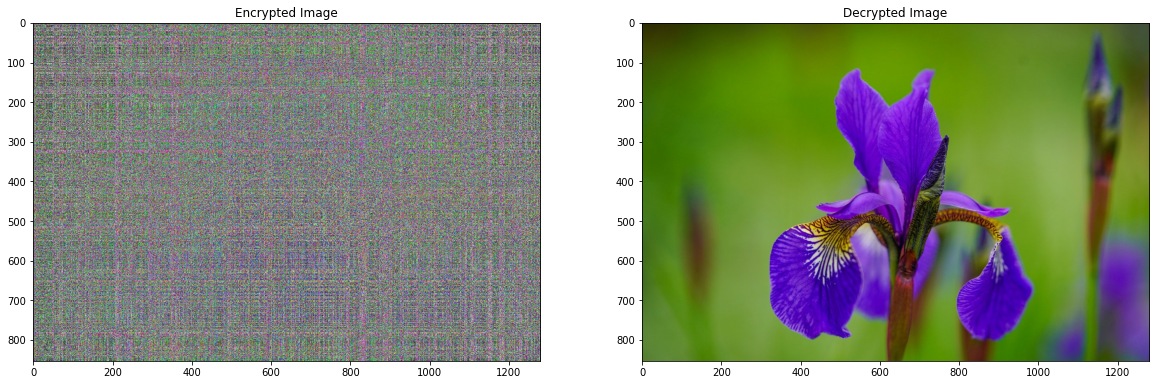

In [ ]:
key_path = "./key.json"
decrypted_path = "./decrypted_image.jpg"
encrypted_path = "./encrypted_image.jpg"


# encrypted_image = read_image(encrypted_path)
encrypted_image = en_image
de_img = decrypt_image(encrypted_image,key_path, aes)
save_image(de_img, decrypted_path)

fig , ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(encrypted_image)
ax[0].set_title("Encrypted Image")

ax[1].imshow(de_img)
ax[1].set_title("Decrypted Image")
fig.show()

# 4.Evaluation

## 4.1 Histogram

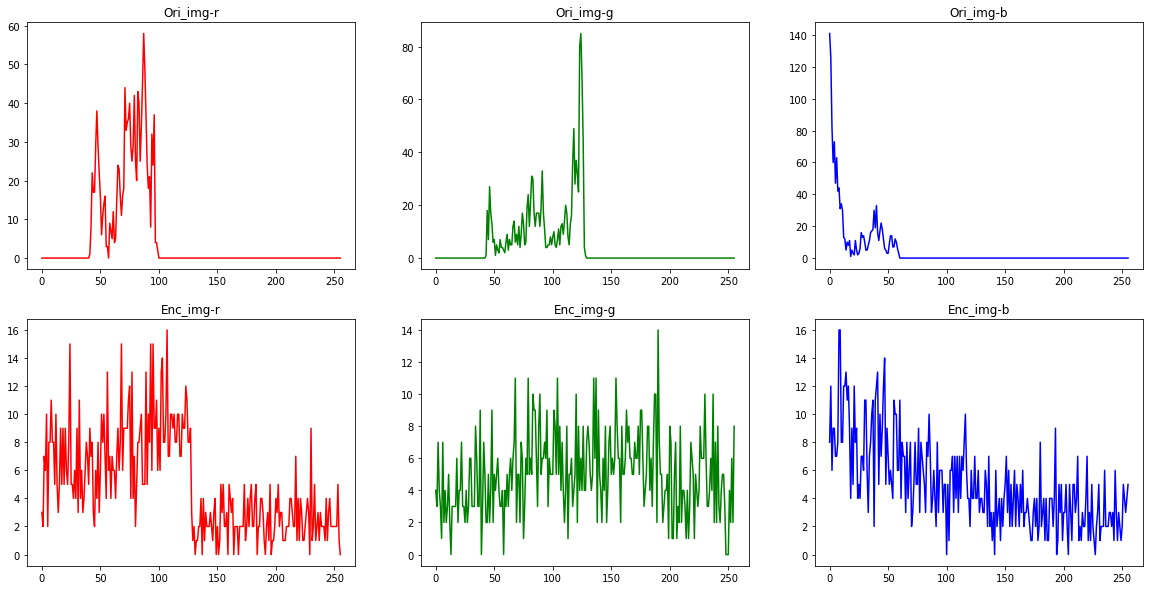

In [ ]:
import cv2 
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for x, c in zip([0,1,2], ["r", "g", "b"]):
    xs = np.arange(256)
    ys = cv2.calcHist(image[:, :, x], [0], None, [256], [0,256])
    ax[0, x].plot(xs, ys.ravel(), color=c)
    ax[0, x].set_title("Ori_img-{}".format(c))

for x, c in zip([0,1,2], ["r", "g", "b"]):
    xs = np.arange(256)
    ys = cv2.calcHist(encrypted_image[:, :, x], [0], None, [256], [0,256])
    ax[1, x].plot(xs, ys.ravel(), color=c)
    ax[1, x].set_title("Enc_img-{}".format(c))

fig.show()

## 4.2 NPCR 

In [ ]:
def calc_npcr(ori_img, enc_img):
  diff = np.array(ori_img) - np.array(enc_img)
  diff = np.abs(diff)
  binary_diff = np.where(diff>0.5, 1, 0)
  total_sum = 0
  for i in range(ori_img.shape[2]):
    total_sum += np.sum(np.sum(binary_diff[:, :, i]))
  total_sum = total_sum / (ori_img.shape[0] * ori_img.shape[1] * ori_img.shape[2])
  
  return total_sum

## 4.3 UACI 

In [ ]:
def calc_uaci(ori_img, enc_img):
  diff = np.array(ori_img) - np.array(enc_img)

  total_sum = 0
  for i in range(ori_img.shape[2]):
    total_sum += sum(sum(np.abs(diff)[:, :, i]))
  total_sum = total_sum * 100.0 / (ori_img.shape[0] * ori_img.shape[1] * ori_img.shape[2])

  return total_sum / 255.0

### Test  trên 1 ảnh với hai tiêu chí 

In [ ]:
print(calc_npcr(image, encrypted_image))

0.9958348598085189


In [ ]:
print(calc_uaci(image, encrypted_image))

0.0594031110881242


### Test trên 10 ảnh lấy trung bình

In [ ]:
import glob
from tqdm.notebook import tqdm
images_path = glob.glob("/content/drive/MyDrive/LTMM/images/*.jpg")
images_path = images_path[:10]

In [ ]:
npcr_values = []
uaci_values = []


for i in tqdm(range(len(images_path))):
  ori_img_test = read_image(images_path[i])

  dict_key = create_key(ori_img_test, ITER_MAX=1, aes=aes)
  save_key(dict_key, save_path=key_path)
  
  enc_img_test = encrypt_image(ori_img_test, aes=aes)
  npcr_values.append(calc_npcr(ori_img_test, enc_img_test))
  uaci_values.append(calc_uaci(ori_img_test, enc_img_test))

print("Mean npcr: ", np.mean(npcr_values))
print("Mean uaci: ", np.mean(uaci_values))

print("Standard deviation npcr: ", np.std(npcr_values))
print("Standard deviation uaci: ", np.std(uaci_values))

  0%|          | 0/10 [00:00<?, ?it/s]

Mean npcr:  0.9959371569685975
Mean uaci:  0.08313483522165267
Standard deviation npcr:  8.12694897216642e-05
Standard deviation uaci:  0.04361998965032771


### Test 10 bộ 2 key trên cùng 1 ảnh

In [ ]:
npcr_values = []
uaci_values = []
images_path = glob.glob("/content/drive/MyDrive/LTMM/images/*.jpg")
random_index = random.randint(0, len(images_path)-1)

for i in tqdm(range(10)):
  ori_img_test = read_image(images_path[random_index])

  # random Key 1
  if i ==0:
    dict_key = create_key(ori_img_test, ITER_MAX=1, aes=aes)
    save_key(dict_key, save_path="./key1.json")
  enc_img_test1 = encrypt_image(ori_img_test, key_path="./key1.json", aes=aes)

  # random Key 2
  if i == 0:
    dict_key = create_key(ori_img_test, ITER_MAX=1, aes=aes)
    save_key(dict_key, save_path="./key2.json")
  enc_img_test2 = encrypt_image(ori_img_test, key_path="./key2.json", aes=aes)

  npcr_values.append(calc_npcr(enc_img_test1, enc_img_test2))

print("Mean npcr: ", np.mean(npcr_values))
print("Standard deviation npcr: ", np.std(npcr_values))

  0%|          | 0/10 [00:00<?, ?it/s]

Mean npcr:  0.9960630063657409
Standard deviation npcr:  1.1102230246251565e-16
